In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [10]:
data_dir = 'C:/Users/hervinho/Downloads/Real'

In [11]:
# Répertoire temporaire pour les données séparées
base_dir = 'C:/Users/hervinho/Downloads/Real_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Créez les répertoires si nécessaire
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Obtenez toutes les sous-classes
classes = os.listdir(data_dir)

# Séparation des ensembles
for class_name in classes:
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Liste des fichiers de la classe actuelle
    images = os.listdir(class_path)
    images = [os.path.join(class_path, img) for img in images]

    # Divisez en 80% (train + validation) et 20% test
    train_val_files, test_files = train_test_split(images, test_size=0.2, random_state=42)

    # Divisez train_val en 80% train et 20% validation
    train_files, validation_files = train_test_split(train_val_files, test_size=0.2, random_state=42)

    # Déplacer les fichiers dans les répertoires appropriés
    for file in train_files:
        dest = os.path.join(train_dir, class_name)
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, dest)

    for file in validation_files:
        dest = os.path.join(validation_dir, class_name)
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, dest)

    for file in test_files:
        dest = os.path.join(test_dir, class_name)
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, dest)

In [12]:
# Générateurs pour les ensembles
datagen = ImageDataGenerator(rescale=1./255)

# Générateur pour l'ensemble d'entraînement
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

# Générateur pour l'ensemble de validation
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 1228 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


In [13]:
# Générateur pour l'ensemble de test
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 384 images belonging to 2 classes.


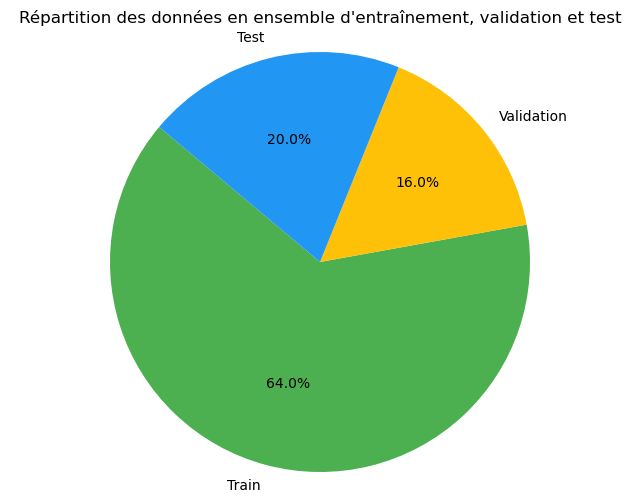

In [14]:
# Total des échantillons
total_samples = train_generator.samples + validation_generator.samples + test_generator.samples

# Répartition des données
train_samples = train_generator.samples
validation_samples = validation_generator.samples
test_samples = test_generator.samples

# Préparer les données pour le graphique
labels = ['Train', 'Validation', 'Test']
sizes = [train_samples, validation_samples, test_samples]
colors = ['#4CAF50', '#FFC107', '#2196F3']  # Couleurs pour chaque catégorie

# Créer le graphique en camembert
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title("Répartition des données en ensemble d'entraînement, validation et test")
plt.axis('equal')  # Assurer un cercle parfait
plt.show()

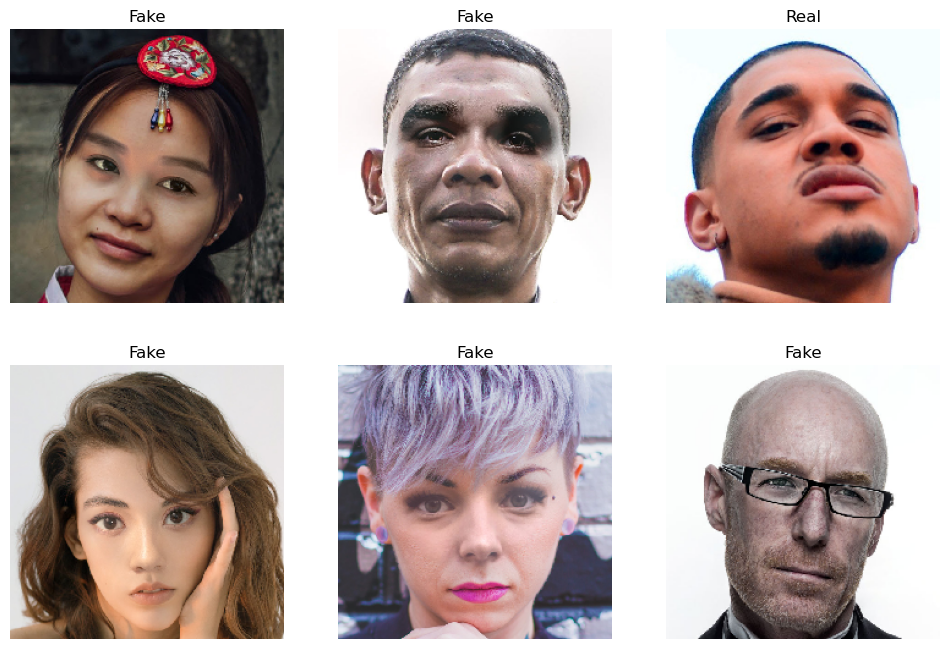

In [15]:
# Obtenir un batch d'images
images, labels = next(train_generator)

# Afficher quelques images
plt.figure(figsize=(12, 8))
for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    plt.title('Fake' if labels[i] == 0 else 'Real')
    plt.axis('off')
plt.show()

In [16]:
def compile_and_train(model, model_name):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=15
    )
    model.save(f'{model_name}.h5')
    return history

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# Charger le modèle pré-entraîné sans les couches supérieures
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model_vgg.layers:
    layer.trainable = False

# Ajouter des couches personnalisées (si vous souhaitez ajouter)
x = base_model_vgg.output
x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)  # Utilisation de sigmoid pour la classification binaire

# Créer le modèle final
model_vgg = Model(inputs=base_model_vgg.input, outputs=x)

# Compiler le modèle
model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history_vgg = model_vgg.fit(train_generator, validation_data=validation_generator, epochs=15)

C:\Users\hervinho\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.5740 - loss: 0.8464 - val_accuracy: 0.5747 - val_loss: 0.7253
Epoch 2/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step - accuracy: 0.7663 - loss: 0.4721 - val_accuracy: 0.6299 - val_loss: 0.6658
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.8171 - loss: 0.4040 - val_accuracy: 0.6461 - val_loss: 0.6498
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.9114 - loss: 0.2913 - val_accuracy: 0.6429 - val_loss: 0.7533
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9297 - loss: 0.2375 - val_accuracy: 0.6331 - val_loss: 0.7175
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 272s 4s/step - accuracy: 0.9439 - loss: 0.2113 - val_accuracy: 0.5974 - val_loss: 0.7259
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9537 - loss: 0.2018 - val_accuracy: 0.6364 - val_loss: 0.7343
Epoch 8/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.9832 - loss: 0.1480 - val_accuracy: 0.6396 - v

In [18]:
from tensorflow.keras.applications import MobileNetV2

# Charger le modèle pré-entraîné sans les couches supérieures
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model_mobilenet.layers:
    layer.trainable = False

# Ajouter des couches personnalisées
x = base_model_mobilenet.output
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions)

# Compiler et entraîner le modèle
history_mobilenet = compile_and_train(model_mobilenet, 'model_mobilenet')

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 44s 516ms/step - accuracy: 0.5162 - loss: 2.5168 - val_accuracy: 0.5822 - val_loss: 1.9109
Epoch 2/15
 1/76 ━━━━━━━━━━━━━━━━━━━━ 12s 167ms/step - accuracy: 0.4375 - loss: 3.1463

C:\Users\hervinho\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.4375 - loss: 3.1463 - val_accuracy: 0.5987 - val_loss: 1.6748
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 494ms/step - accuracy: 0.8237 - loss: 0.6333 - val_accuracy: 0.5855 - val_loss: 2.0501
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - accuracy: 0.6875 - loss: 0.9826 - val_accuracy: 0.5921 - val_loss: 1.9839
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 36s 480ms/step - accuracy: 0.9079 - loss: 0.2662 - val_accuracy: 0.6118 - val_loss: 2.1410
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 1.0000 - loss: 0.0392 - val_accuracy: 0.6020 - val_loss: 2.3135
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 486ms/step - accuracy: 0.9213 - loss: 0.2230 - val_accuracy: 0.5526 - val_loss: 3.8582
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.8125 - loss: 1.4195 - val_accuracy: 0.5428 - val_loss: 3.9924
Epoch 9/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 37s 484ms/step - accuracy: 0.9414 - loss: 0.1467 - val_accuracy: 0.6086 - v

In [19]:
from tensorflow.keras.applications import DenseNet121

# Charger le modèle pré-entraîné sans les couches supérieures
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model_densenet.layers:
    layer.trainable = False

# Ajouter des couches personnalisées
x = base_model_densenet.output
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions)

# Compiler et entraîner le modèle
history_densenet = compile_and_train(model_densenet, 'model_densenet')

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5140 - loss: 1.6217 - val_accuracy: 0.6480 - val_loss: 1.1392
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.6250 - loss: 1.3855 - val_accuracy: 0.6645 - val_loss: 1.0608
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7963 - loss: 0.5645 - val_accuracy: 0.6151 - val_loss: 1.2512
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 22s 286ms/step - accuracy: 0.8750 - loss: 0.2955 - val_accuracy: 0.6184 - val_loss: 1.3326
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8733 - loss: 0.3615 - val_accuracy: 0.5987 - val_loss: 1.4346
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.9375 - loss: 0.3825 - val_accuracy: 0.6020 - val_loss: 1.4922
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8820 - loss: 0.2602 - val_accuracy: 0.6151 - val_loss: 1.4757
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.9375 - loss: 0.2112 - val_accuracy: 0.62

In [20]:
from tensorflow.keras.applications import ResNet50

# Charger le modèle pré-entraîné sans les couches supérieures
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Geler les couches du modèle de base
for layer in base_model_resnet.layers:
    layer.trainable = False

# Ajouter des couches personnalisées
x = base_model_resnet.output
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Compiler et entraîner le modèle
history_resnet = compile_and_train(model_resnet, 'model_resnet')

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5177 - loss: 1.3022 - val_accuracy: 0.5066 - val_loss: 0.7529
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 267ms/step - accuracy: 0.5000 - loss: 0.8586 - val_accuracy: 0.5329 - val_loss: 0.7030
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.5496 - loss: 0.8552 - val_accuracy: 0.6217 - val_loss: 0.6780
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.4375 - loss: 0.6572 - val_accuracy: 0.5132 - val_loss: 0.8599
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5545 - loss: 0.7363 - val_accuracy: 0.5296 - val_loss: 0.7659
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.7500 - loss: 0.5293 - val_accuracy: 0.5296 - val_loss: 0.6933
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.5617 - loss: 0.8667 - val_accuracy: 0.5888 - val_loss: 0.7134
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 240ms/step - accuracy: 0.8125 - loss: 0.4765 - val_accuracy: 0.60

In [21]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Charger le modèle pré-entraîné sans les couches supérieures
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Débloquer quelques couches pour permettre l'apprentissage transféré
for layer in base_model_vgg.layers[:-4]:  # Geler toutes sauf les 4 dernières couches
    layer.trainable = False

# Ajouter des couches personnalisées
x = base_model_vgg.output
x = Flatten()(x)
x = Dense(256)(x)  # Augmenter légèrement la capacité
x = BatchNormalization()(x)  # Normalisation de batch
x = LeakyReLU(alpha=0.1)(x)  # LeakyReLU avec alpha réduit
x = Dropout(0.3)(x)  # Réduction du dropout
x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

# Créer le modèle final
model_notre_model = Model(inputs=base_model_vgg.input, outputs=x)

# Compiler le modèle
model_notre_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback avec une patience plus élevée
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entraîner le modèle
history_notre_model = model_notre_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,  # Augmentation du nombre d'époques
    callbacks=[early_stopping]
)

C:\Users\hervinho\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.5568 - loss: 0.7582 - val_accuracy: 0.5000 - val_loss: 8.4192
Epoch 2/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 284s 4s/step - accuracy: 0.5681 - loss: 0.7117 - val_accuracy: 0.5455 - val_loss: 1.3430
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 313s 4s/step - accuracy: 0.6131 - loss: 0.6568 - val_accuracy: 0.5032 - val_loss: 1.4157
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 295s 4s/step - accuracy: 0.6147 - loss: 0.6570 - val_accuracy: 0.5812 - val_loss: 0.9269
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 304s 4s/step - accuracy: 0.6745 - loss: 0.6136 - val_accuracy: 0.6396 - val_loss: 0.7315
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 294s 4s/step - accuracy: 0.7211 - loss: 0.5530 - val_accuracy: 0.5519 - val_loss: 1.1825
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.7518 - loss: 0.5049 - val_accuracy: 0.6039 - val_loss: 1.1402
Epoch 8/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.7784 - loss: 0.4604 - val_accuracy: 0.6623 - v

In [22]:
from tensorflow.keras.utils import plot_model

# Générer une représentation graphique du modèle
plot_model(model_notre_model, to_file='vgg16_model_structure.png', show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [23]:
def plot_history(history, model_name):
    # Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'], label='Entraînement')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Précision du modèle {model_name}')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    plt.show()

    # Loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Entraînement')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'Perte du modèle {model_name}')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()

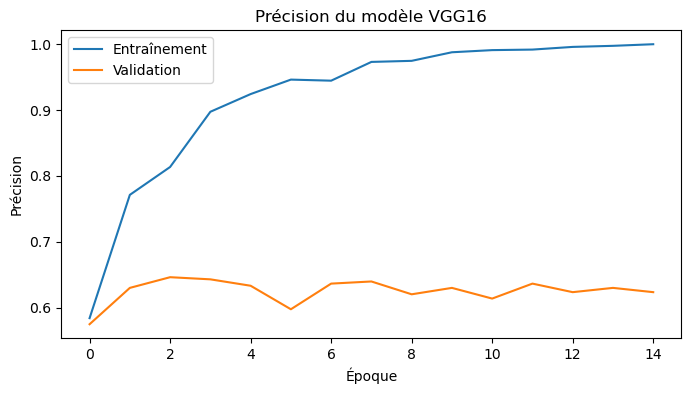

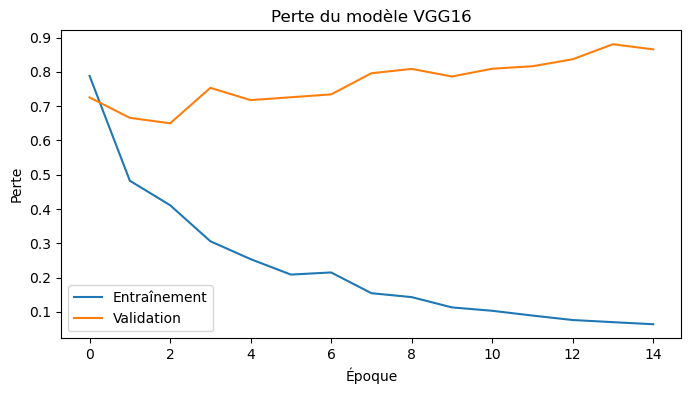

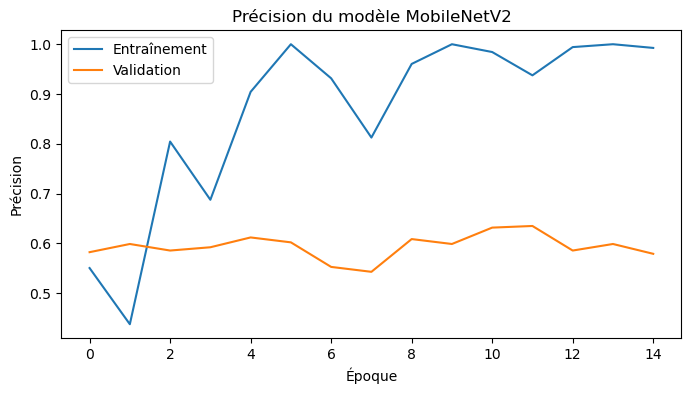

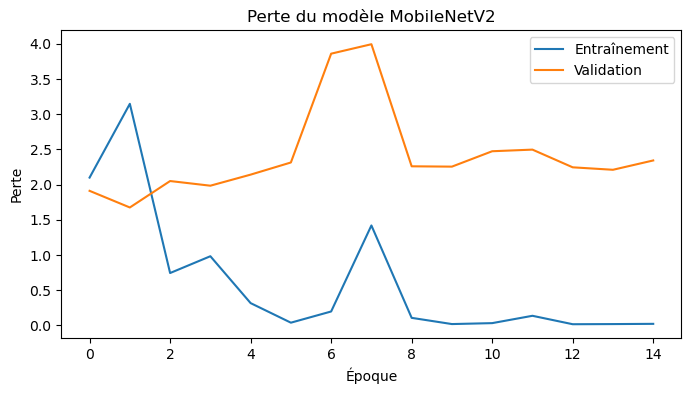

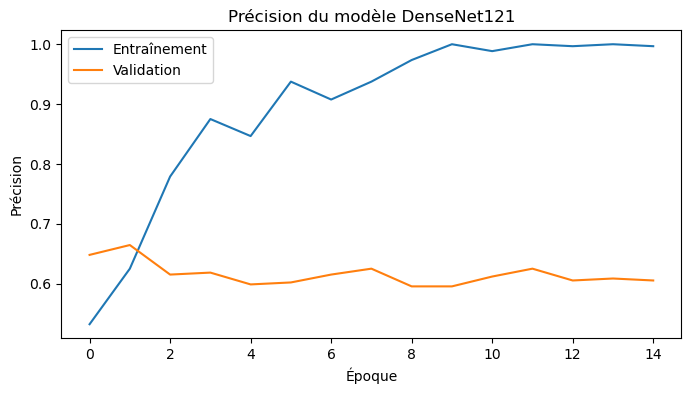

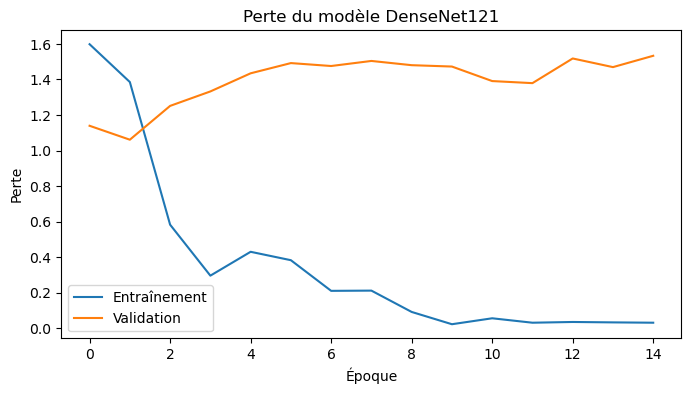

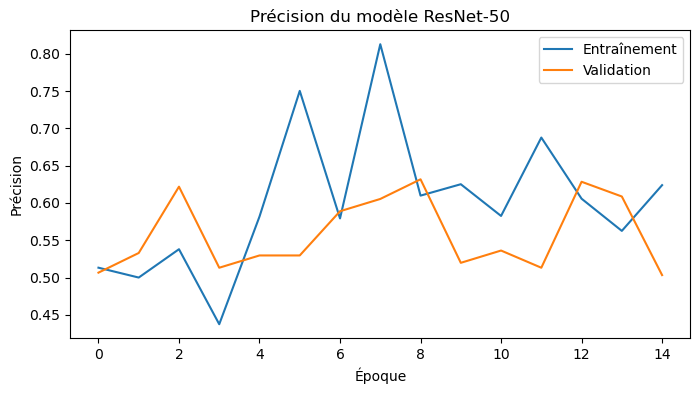

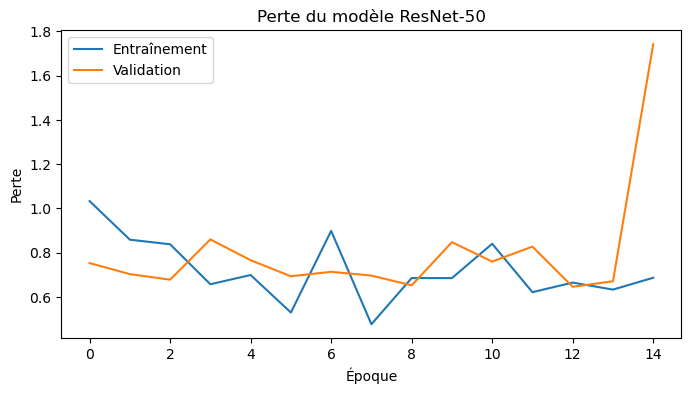

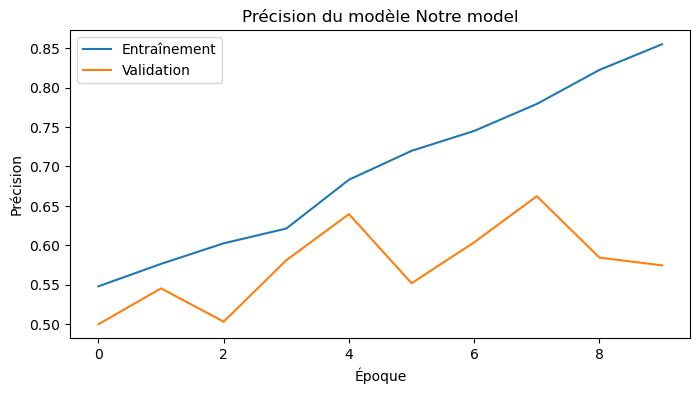

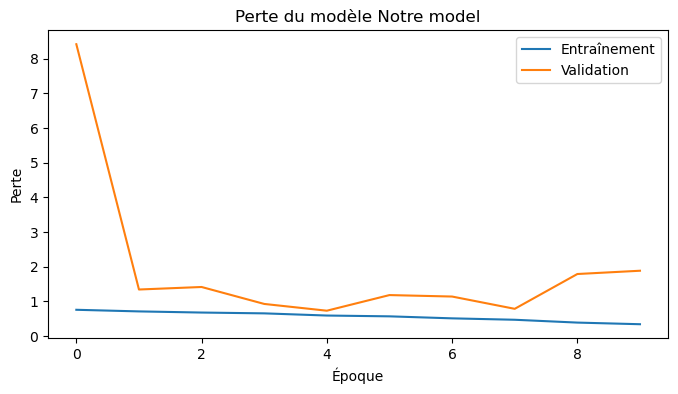

In [24]:
plot_history(history_vgg, 'VGG16')
plot_history(history_mobilenet, 'MobileNetV2')
plot_history(history_densenet, 'DenseNet121')
plot_history(history_resnet, 'ResNet-50')
plot_history(history_notre_model, 'Notre model')

In [25]:
def evaluate_model(model, model_name):
    # Prédictions sur le jeu de test
    Y_pred = model.predict(test_generator)
    y_pred = np.round(Y_pred).astype(int).flatten()
    y_true = test_generator.classes

    # Rapport de classification
    print(f"Rapport de classification pour le modèle {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matrice de confusion pour le modèle {model_name}')
    plt.show()

24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step
Rapport de classification pour le modèle VGG16:

              precision    recall  f1-score   support

        Fake       0.60      0.63      0.62       192
        Real       0.61      0.58      0.60       192

    accuracy                           0.61       384
   macro avg       0.61      0.61      0.61       384
weighted avg       0.61      0.61      0.61       384



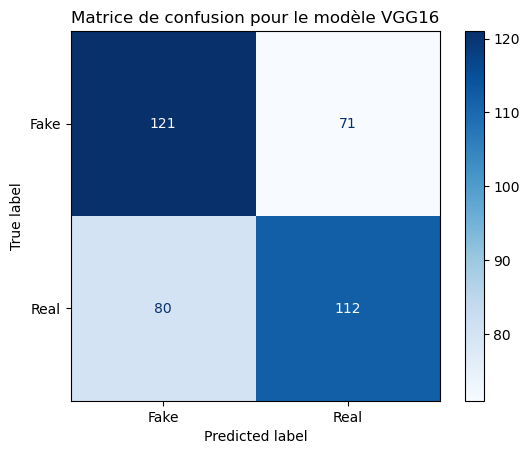

24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step
Rapport de classification pour le modèle MobileNetV2:

              precision    recall  f1-score   support

        Fake       0.59      0.62      0.61       192
        Real       0.60      0.58      0.59       192

    accuracy                           0.60       384
   macro avg       0.60      0.60      0.60       384
weighted avg       0.60      0.60      0.60       384



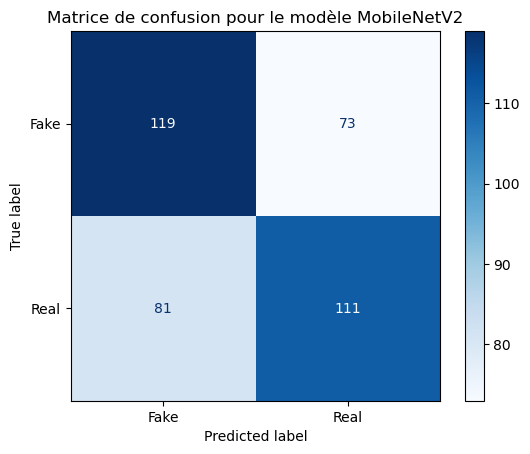

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 841ms/step
Rapport de classification pour le modèle DenseNet121:

              precision    recall  f1-score   support

        Fake       0.57      0.66      0.61       192
        Real       0.59      0.49      0.54       192

    accuracy                           0.58       384
   macro avg       0.58      0.58      0.57       384
weighted avg       0.58      0.58      0.57       384



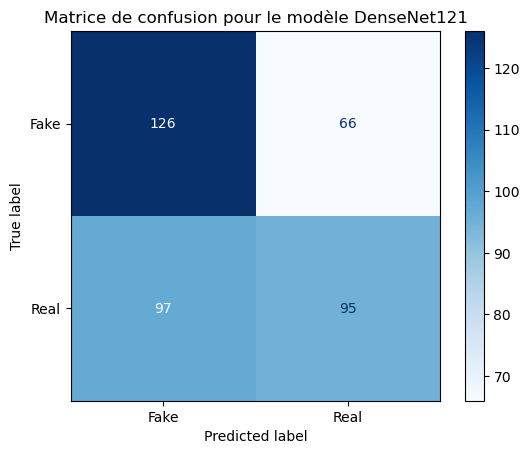

24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 877ms/step
Rapport de classification pour le modèle ResNet-50:

              precision    recall  f1-score   support

        Fake       0.50      0.99      0.67       192
        Real       0.50      0.01      0.01       192

    accuracy                           0.50       384
   macro avg       0.50      0.50      0.34       384
weighted avg       0.50      0.50      0.34       384



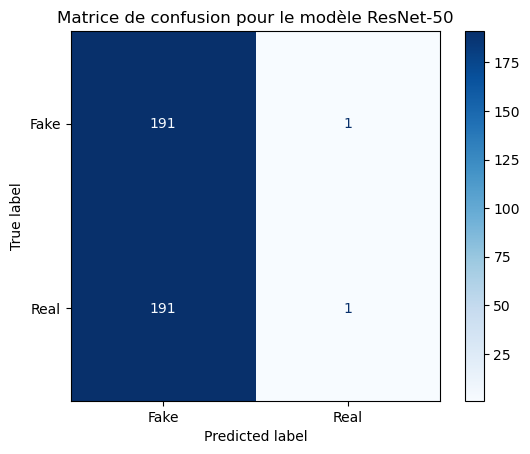

24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step
Rapport de classification pour le modèle Notre model:

              precision    recall  f1-score   support

        Fake       0.55      0.90      0.68       192
        Real       0.71      0.26      0.38       192

    accuracy                           0.58       384
   macro avg       0.63      0.58      0.53       384
weighted avg       0.63      0.58      0.53       384



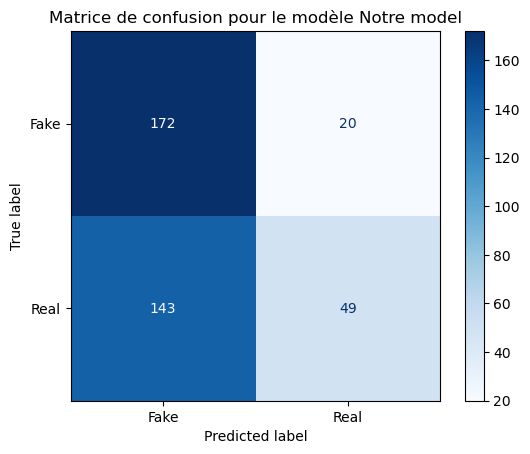

In [26]:
# Charger les modèles sauvegardés (si nécessaire)
# model_vgg = tf.keras.models.load_model('model_vgg.h5')
# model_mobilenet = tf.keras.models.load_model('model_mobilenet.h5')
# model_densenet = tf.keras.models.load_model('model_densenet.h5')
# model_resnet = tf.keras.models.load_model('model_resnet.h5')

evaluate_model(model_vgg, 'VGG16')
evaluate_model(model_mobilenet, 'MobileNetV2')
evaluate_model(model_densenet, 'DenseNet121')
evaluate_model(model_resnet, 'ResNet-50')
evaluate_model(model_notre_model, 'Notre model')

In [45]:
models = ['VGG16', 'MobileNetV2', 'DenseNet121', 'ResNet-50', 'Notre model']
accuracies = []
precisions = []
recalls = []
f1_scores = []

for model_name, model in zip(models, [model_vgg, model_mobilenet, model_densenet, model_resnet]):
    Y_pred = model.predict(test_generator)
    y_pred = np.round(Y_pred).astype(int).flatten()
    y_true = test_generator.classes

    report = classification_report(y_true, y_pred, output_dict=True, target_names=['Fake', 'Real'])
    accuracies.append(report['accuracy'])
    precisions.append(report['weighted avg']['precision'])
    recalls.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])

24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 320ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 659ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 833ms/step


In [48]:
models = ['VGG16', 'MobileNetV2', 'DenseNet121', 'ResNet-50', 'Notre model']
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Liste des modèles que vous souhaitez évaluer
for model_name, model in zip(models, [model_vgg, model_mobilenet, model_densenet, model_resnet]):
    print(f"Évaluation du modèle : {model_name}")
    
    # Prédictions sur le jeu de données de test
    Y_pred = model.predict(test_generator)
    print(f"Shape de Y_pred : {Y_pred.shape}")  # Vérifier la forme des prédictions
    
    y_pred = np.round(Y_pred).astype(int).flatten()  # Arrondir les prédictions et les transformer en tableau plat
    y_true = test_generator.classes  # Récupérer les vraies étiquettes
    print(f"Shape de y_true : {y_true.shape}")  # Vérifier la forme des vraies étiquettes

    # Calcul du rapport de classification
    report = classification_report(y_true, y_pred, output_dict=True, target_names=['Fake', 'Real'])
    print(report)  # Afficher le rapport de classification pour déboguer
    
    accuracies.append(report['accuracy'])
    precisions.append(report['weighted avg']['precision'])
    recalls.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])

# Vérifiez que vous avez bien des valeurs dans les listes
print(f"Accuracies: {accuracies}")
print(f"Precisions: {precisions}")
print(f"Recalls: {recalls}")
print(f"F1 Scores: {f1_scores}")


Évaluation du modèle : VGG16
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step
Shape de Y_pred : (384, 1)
Shape de y_true : (384,)
{'Fake': {'precision': 0.6019900497512438, 'recall': 0.6302083333333334, 'f1-score': 0.6157760814249363, 'support': 192.0}, 'Real': {'precision': 0.6120218579234973, 'recall': 0.5833333333333334, 'f1-score': 0.5973333333333334, 'support': 192.0}, 'accuracy': 0.6067708333333334, 'macro avg': {'precision': 0.6070059538373705, 'recall': 0.6067708333333334, 'f1-score': 0.6065547073791349, 'support': 384.0}, 'weighted avg': {'precision': 0.6070059538373705, 'recall': 0.6067708333333334, 'f1-score': 0.6065547073791349, 'support': 384.0}}
Évaluation du modèle : MobileNetV2
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step
Shape de Y_pred : (384, 1)
Shape de y_true : (384,)
{'Fake': {'precision': 0.595, 'recall': 0.6197916666666666, 'f1-score': 0.6071428571428571, 'support': 192.0}, 'Real': {'precision': 0.6032608695652174, 'recall': 0.578125, 'f1-score': 0.5904255319148937, 'support'

24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 611ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 685ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step


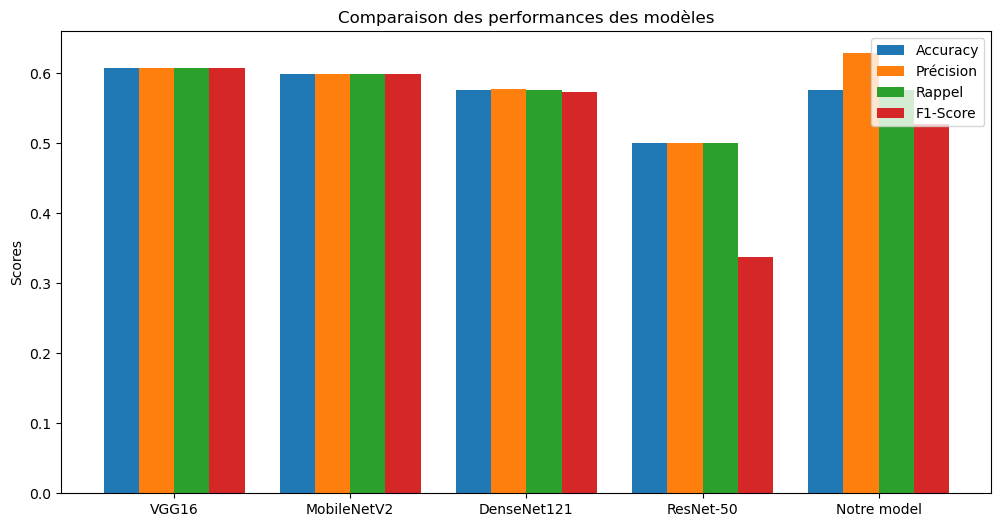

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Liste des modèles
models = ['VGG16', 'MobileNetV2', 'DenseNet121', 'ResNet-50', 'Notre model']

# Dictionnaire pour stocker les valeurs des métriques
results = {
    'Accuracy': [],
    'Précision': [],
    'Rappel': [],
    'F1-Score': []
}

# Exemple d'initialisation des modèles (remplacez-les par vos vrais modèles)
# models = [model_vgg, model_mobilenet, model_densenet, model_resnet]

# On suppose que vous avez une fonction pour prédire et obtenir les résultats
for model_name, model in zip(models, [model_vgg, model_mobilenet, model_densenet, model_resnet, model_notre_model]):
    Y_pred = model.predict(test_generator)  # prédiction du modèle
    y_pred = np.round(Y_pred).astype(int).flatten()  # arrondi et conversion en int
    y_true = test_generator.classes  # classes réelles

    # Génération du rapport de classification
    report = classification_report(y_true, y_pred, output_dict=True, target_names=['Fake', 'Real'])

    # Extraction des métriques du rapport de classification
    results['Accuracy'].append(report['accuracy'])
    results['Précision'].append(report['weighted avg']['precision'])
    results['Rappel'].append(report['weighted avg']['recall'])
    results['F1-Score'].append(report['weighted avg']['f1-score'])

# Position des modèles sur l'axe x
x = np.arange(len(models))  # Emplacement des barres
width = 0.2  # Largeur des barres

# Création du graphique
plt.figure(figsize=(12, 6))

# Positionnement dynamique des barres (pour chaque métrique)
for i, (metric, values) in enumerate(results.items()):
    plt.bar(x + (i - 1.5) * width, values, width, label=metric)

# Titres et légendes
plt.ylabel('Scores')
plt.title('Comparaison des performances des modèles')
plt.xticks(x, models)  # Afficher les noms des modèles sur l’axe des x
plt.legend()

# Affichage du graphique
plt.show()
